In [163]:
import os                   #Se importan funcionalidades del sistema operativo
import tensorflow as tf     #Librería TensorFlow (GPU: ON)
import numpy as np          #Librería para manejo de matrices
import cv2                  #Importar imagenes, reajustarla, etc.
import random               
from tqdm import tqdm       #Librería 100%|██████████████████████████████████████████████████████████████████████████████████| 

print(tf.__version__)
dir_img_señaleticas = "D:\kaggle\disco pare\Principales" #"D:/carpeta/carpeta 2/imagenes/.../"
dir_test_img = "D:/kaggle/disco pare/validacion" #"D:/carpeta/carpeta 2/imagenes/.../"
lr = 1e-4  #tasa de aprendizaje 
ancho = 400 #ancho de la imagen
alto = 400  #alto de la imagen
canales = 1 #canales de la imagen

NOMBRE_MODELO = '23-09-2018-V3-{}-{}.model'.format(lr, 'CNN') #nombre del modelo a crear

1.8.0


In [164]:
from PIL import Image
#Image.save(fp, format=None, **params)
def rotar_imagenes(ruta, anugloInicial, anguloFinal, cantidad):
    angulo = (anguloFinal - anugloInicial)/cantidad
    contador = 30
    for img in tqdm(os.listdir(ruta)):
        nombre = img.split('.')[1]
        path = os.path.join(dir_img_señaleticas,img)
        im = Image.open(path)
        for i in range(cantidad):
            rotacion = anugloInicial + i * angulo
            rotar = im.rotate(rotacion)
            rotar.save("{}.{}.jpg".format(contador,nombre))
            contador+=1
            
#rotar_imagenes(dir_img_señaleticas,-90,90,90)  

In [167]:
def ajustar_nombres():
    for i,img in tqdm(enumerate(os.listdir(dir_img_señaleticas))):
        #numero.nombre.formato
        nombre = str(i) + "." + img.split('.')[1] + ".jpg"
        os.rename(img, str(nombre))
        

def etiquetas(nombre): #Así, si es que hay más señaleticas, se puede agrandar facilmente.
    if nombre == "DISCO-PARE":
        return [1,0]
    if nombre == "CEDA-EL-PASO":
        return [0,1]
        
def entrenamientoImagenes():
    datos_entrenamiento=[]
    for i in tqdm(os.listdir(dir_img_señaleticas)):
        etiqueta = etiquetas(i.split("_")[0])
        ruta_completa = os.path.join(dir_img_señaleticas,i) #D:\img\disco pare\imagenes_señaleticas\imagen
        #img = cv2.imread(ruta_completa)
        img = cv2.imread(ruta_completa,cv2.IMREAD_GRAYSCALE)
        img = cv2.equalizeHist(img)
        img = cv2.resize(img, (ancho,alto))
        datos_entrenamiento.append([np.array(img),np.array(etiqueta)])
    random.shuffle(datos_entrenamiento)
    return datos_entrenamiento

def crear_datos_test():
    testing_data = []
    for img in tqdm(os.listdir(dir_test_img)):
        path = os.path.join(dir_test_img,img)
        etiqueta = etiquetas(img.split("_")[0])
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.equalizeHist(img)
        img = cv2.resize(img, (ancho,alto))
        testing_data.append([np.array(img), np.array(etiqueta)])  
    random.shuffle(testing_data)
    np.save('datos_de_test.npy', testing_data)
    return testing_data

In [168]:
'''Se modifica el color, el histograma y las dimensiones espaciales de todas las imagenes, además de guardar su respectiva 
    etiqueta.
    
    
    [IMAGEN EN FORMA DE MATRIZ , VALOR ENTERO] , entendiendo como valor entero un número discreto que represente una clase.
                                                 ÈJ: 1-> Disco Pare / 0-> Ceda el Paso.
    '''
imagenes_entrenamiento = entrenamientoImagenes()
print(len(imagenes_entrenamiento))
# Si ya tengo los datos:
#imagenes_entrenamiento = np.load('datos_de_test.npy')

100%|██████████████████████████████████████████████████████████████████████████████| 3858/3858 [04:58<00:00, 12.94it/s]


3858


In [169]:
'''Las imagenes ya generadas y modificadas se guardan en la variable entrenamiento.'''
entrenamiento = imagenes_entrenamiento[:]
print(len(entrenamiento))
#prueba = crear_datos_test()
#len(prueba)

3858


In [170]:
'''Se Guardan las imagenes transfdormadas en array en X, y en Y las etiquetas correspondientes'''
X = np.array([i[0] for i in entrenamiento]).reshape(-1,400,400,1)
Y = [ i[1] for i in entrenamiento] 

#test_x = np.array([i[0] for i in prueba]).reshape(-1,ancho,alto,1)
#test_y = [i[1] for i in prueba]

In [171]:
'''Librerias que ocupo para el entrenamiento'''
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras import losses
from keras.optimizers import SGD, Adam
import keras
from keras.layers import Convolution2D, GlobalAveragePooling1D, MaxPooling2D

model = Sequential()

In [172]:
'''Modelo Red Neuronal Convolucional

    Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_77 (Conv2D)           (None, 398, 398, 32)      320       
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 199, 199, 32)      0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 197, 197, 64)      18496     
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 98, 98, 64)        0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 98, 98, 64)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 97, 97, 128)       32896     
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 48, 48, 128)       0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 48, 48, 128)       0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 46, 46, 64)        73792     
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 21, 21, 32)        18464     
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 7, 7, 32)          0          La imagen inicial de 400x400x1 termina con un tamaño de 7x7x32
_________________________________________________________________
flatten_14 (Flatten)         (None, 1568)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 1024)              1606656   
_________________________________________________________________
dropout_39 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 2050      
=================================================================
Total params: 1,752,674
Trainable params: 1,752,674
Non-trainable params: 0
'''
from keras.layers import Dense

model.add(Convolution2D(32,(3, 3), activation='relu', input_shape=(ancho, alto, 1), data_format="channels_last"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64,(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Convolution2D(128,(2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Convolution2D(64,(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Convolution2D(32,(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(2, activation='softmax'))

#sgd = SGD(lr=lr, decay=1e-6)
adam = Adam(lr=lr)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()
X = np.array(X)
Y = np.array(Y)

#test_x = np.array(test_x)
#test_y = np.array(test_y)
model.fit(X, Y, epochs=50, validation_split=0.2)
#score = model.evaluate(test_x, test_y, batch_size=20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_77 (Conv2D)           (None, 398, 398, 32)      320       
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 199, 199, 32)      0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 197, 197, 64)      18496     
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 98, 98, 64)        0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 98, 98, 64)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 97, 97, 128)       32896     
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 48, 48, 128)       0         
__________

3086/3086 [==============================] - ETA: 24s - loss: 9.5701 - acc: 0.40 - ETA: 24s - loss: 7.8074 - acc: 0.51 - ETA: 24s - loss: 8.7307 - acc: 0.45 - ETA: 23s - loss: 8.1851 - acc: 0.49 - ETA: 23s - loss: 7.8576 - acc: 0.51 - ETA: 23s - loss: 7.7623 - acc: 0.51 - ETA: 23s - loss: 8.0740 - acc: 0.49 - ETA: 23s - loss: 7.7584 - acc: 0.51 - ETA: 22s - loss: 7.7359 - acc: 0.51 - ETA: 22s - loss: 7.7682 - acc: 0.51 - ETA: 22s - loss: 7.7946 - acc: 0.51 - ETA: 21s - loss: 7.9006 - acc: 0.50 - ETA: 21s - loss: 7.7966 - acc: 0.51 - ETA: 21s - loss: 7.8153 - acc: 0.51 - ETA: 21s - loss: 7.7980 - acc: 0.51 - ETA: 20s - loss: 7.9402 - acc: 0.50 - ETA: 20s - loss: 7.9472 - acc: 0.50 - ETA: 20s - loss: 7.8695 - acc: 0.51 - ETA: 20s - loss: 7.9325 - acc: 0.50 - ETA: 19s - loss: 7.8915 - acc: 0.50 - ETA: 19s - loss: 7.9234 - acc: 0.50 - ETA: 19s - loss: 7.7922 - acc: 0.51 - ETA: 19s - loss: 7.8038 - acc: 0.51 - ETA: 18s - loss: 7.8565 - acc: 0.51 - ETA: 18s - loss: 7.8847 - acc: 0.50 - ETA: 

3086/3086 [==============================] - ETA: 24s - loss: 5.2925 - acc: 0.62 - ETA: 24s - loss: 6.7662 - acc: 0.53 - ETA: 24s - loss: 6.1911 - acc: 0.55 - ETA: 23s - loss: 6.4064 - acc: 0.55 - ETA: 23s - loss: 6.7046 - acc: 0.53 - ETA: 23s - loss: 6.8518 - acc: 0.51 - ETA: 23s - loss: 7.0613 - acc: 0.49 - ETA: 22s - loss: 7.0797 - acc: 0.49 - ETA: 22s - loss: 6.7785 - acc: 0.51 - ETA: 22s - loss: 6.5575 - acc: 0.53 - ETA: 22s - loss: 6.4281 - acc: 0.53 - ETA: 21s - loss: 6.4343 - acc: 0.54 - ETA: 21s - loss: 6.4488 - acc: 0.54 - ETA: 21s - loss: 6.4624 - acc: 0.54 - ETA: 21s - loss: 6.5214 - acc: 0.53 - ETA: 20s - loss: 6.5703 - acc: 0.53 - ETA: 20s - loss: 6.5863 - acc: 0.53 - ETA: 20s - loss: 6.5973 - acc: 0.53 - ETA: 20s - loss: 6.4537 - acc: 0.54 - ETA: 19s - loss: 6.3076 - acc: 0.55 - ETA: 19s - loss: 6.3217 - acc: 0.55 - ETA: 19s - loss: 6.2725 - acc: 0.55 - ETA: 18s - loss: 6.2926 - acc: 0.55 - ETA: 18s - loss: 6.2282 - acc: 0.55 - ETA: 18s - loss: 6.2236 - acc: 0.55 - ETA: 

3086/3086 [==============================] - ETA: 24s - loss: 0.7167 - acc: 0.59 - ETA: 24s - loss: 0.6996 - acc: 0.60 - ETA: 23s - loss: 0.6984 - acc: 0.58 - ETA: 23s - loss: 0.7101 - acc: 0.57 - ETA: 23s - loss: 0.7161 - acc: 0.53 - ETA: 23s - loss: 0.7149 - acc: 0.53 - ETA: 23s - loss: 0.7263 - acc: 0.52 - ETA: 22s - loss: 0.7253 - acc: 0.52 - ETA: 22s - loss: 0.7243 - acc: 0.52 - ETA: 22s - loss: 0.7328 - acc: 0.51 - ETA: 22s - loss: 0.7336 - acc: 0.50 - ETA: 21s - loss: 0.7260 - acc: 0.51 - ETA: 21s - loss: 0.7228 - acc: 0.52 - ETA: 21s - loss: 0.7199 - acc: 0.53 - ETA: 21s - loss: 0.7175 - acc: 0.53 - ETA: 20s - loss: 0.7175 - acc: 0.53 - ETA: 20s - loss: 0.7186 - acc: 0.53 - ETA: 20s - loss: 0.7199 - acc: 0.53 - ETA: 19s - loss: 0.7182 - acc: 0.53 - ETA: 19s - loss: 0.7138 - acc: 0.53 - ETA: 19s - loss: 0.7111 - acc: 0.54 - ETA: 19s - loss: 0.7091 - acc: 0.54 - ETA: 18s - loss: 0.7122 - acc: 0.53 - ETA: 18s - loss: 0.7115 - acc: 0.53 - ETA: 18s - loss: 0.7099 - acc: 0.54 - ETA: 

3086/3086 [==============================] - ETA: 24s - loss: 0.6783 - acc: 0.65 - ETA: 24s - loss: 0.6256 - acc: 0.64 - ETA: 24s - loss: 0.6271 - acc: 0.66 - ETA: 24s - loss: 0.6144 - acc: 0.66 - ETA: 24s - loss: 0.6192 - acc: 0.65 - ETA: 23s - loss: 0.6212 - acc: 0.65 - ETA: 23s - loss: 0.5946 - acc: 0.68 - ETA: 23s - loss: 0.6042 - acc: 0.66 - ETA: 23s - loss: 0.6062 - acc: 0.65 - ETA: 22s - loss: 0.5993 - acc: 0.66 - ETA: 22s - loss: 0.6022 - acc: 0.66 - ETA: 22s - loss: 0.6123 - acc: 0.65 - ETA: 22s - loss: 0.6066 - acc: 0.65 - ETA: 21s - loss: 0.6167 - acc: 0.64 - ETA: 21s - loss: 0.6213 - acc: 0.64 - ETA: 21s - loss: 0.6244 - acc: 0.64 - ETA: 21s - loss: 0.6291 - acc: 0.63 - ETA: 20s - loss: 0.6350 - acc: 0.63 - ETA: 20s - loss: 0.6413 - acc: 0.63 - ETA: 20s - loss: 0.6401 - acc: 0.64 - ETA: 20s - loss: 0.6410 - acc: 0.63 - ETA: 19s - loss: 0.6394 - acc: 0.64 - ETA: 19s - loss: 0.6400 - acc: 0.63 - ETA: 19s - loss: 0.6388 - acc: 0.63 - ETA: 18s - loss: 0.6369 - acc: 0.63 - ETA: 

3086/3086 [==============================] - ETA: 24s - loss: 0.4678 - acc: 0.71 - ETA: 24s - loss: 0.3714 - acc: 0.81 - ETA: 24s - loss: 0.3901 - acc: 0.80 - ETA: 24s - loss: 0.3632 - acc: 0.82 - ETA: 24s - loss: 0.3856 - acc: 0.81 - ETA: 23s - loss: 0.3641 - acc: 0.82 - ETA: 23s - loss: 0.3679 - acc: 0.83 - ETA: 23s - loss: 0.3531 - acc: 0.83 - ETA: 23s - loss: 0.3545 - acc: 0.84 - ETA: 22s - loss: 0.3487 - acc: 0.84 - ETA: 22s - loss: 0.3469 - acc: 0.84 - ETA: 22s - loss: 0.3589 - acc: 0.83 - ETA: 22s - loss: 0.3634 - acc: 0.83 - ETA: 21s - loss: 0.3478 - acc: 0.84 - ETA: 21s - loss: 0.3482 - acc: 0.84 - ETA: 21s - loss: 0.3470 - acc: 0.84 - ETA: 21s - loss: 0.3594 - acc: 0.83 - ETA: 20s - loss: 0.3575 - acc: 0.83 - ETA: 20s - loss: 0.3614 - acc: 0.83 - ETA: 20s - loss: 0.3618 - acc: 0.83 - ETA: 20s - loss: 0.3570 - acc: 0.83 - ETA: 19s - loss: 0.3591 - acc: 0.83 - ETA: 19s - loss: 0.3653 - acc: 0.83 - ETA: 19s - loss: 0.3626 - acc: 0.83 - ETA: 18s - loss: 0.3702 - acc: 0.83 - ETA: 

3086/3086 [==============================] - ETA: 24s - loss: 0.1042 - acc: 0.96 - ETA: 24s - loss: 0.1670 - acc: 0.93 - ETA: 24s - loss: 0.2946 - acc: 0.87 - ETA: 24s - loss: 0.2700 - acc: 0.89 - ETA: 24s - loss: 0.2428 - acc: 0.89 - ETA: 23s - loss: 0.2440 - acc: 0.89 - ETA: 23s - loss: 0.2311 - acc: 0.89 - ETA: 23s - loss: 0.2328 - acc: 0.89 - ETA: 23s - loss: 0.2264 - acc: 0.89 - ETA: 22s - loss: 0.2268 - acc: 0.90 - ETA: 22s - loss: 0.2290 - acc: 0.90 - ETA: 22s - loss: 0.2244 - acc: 0.90 - ETA: 22s - loss: 0.2192 - acc: 0.90 - ETA: 21s - loss: 0.2213 - acc: 0.90 - ETA: 21s - loss: 0.2280 - acc: 0.90 - ETA: 21s - loss: 0.2257 - acc: 0.91 - ETA: 21s - loss: 0.2257 - acc: 0.90 - ETA: 20s - loss: 0.2237 - acc: 0.91 - ETA: 20s - loss: 0.2252 - acc: 0.91 - ETA: 20s - loss: 0.2206 - acc: 0.91 - ETA: 20s - loss: 0.2130 - acc: 0.91 - ETA: 19s - loss: 0.2151 - acc: 0.91 - ETA: 19s - loss: 0.2092 - acc: 0.92 - ETA: 19s - loss: 0.2107 - acc: 0.92 - ETA: 18s - loss: 0.2158 - acc: 0.91 - ETA: 

3086/3086 [==============================] - ETA: 24s - loss: 0.2709 - acc: 0.90 - ETA: 24s - loss: 0.1652 - acc: 0.95 - ETA: 24s - loss: 0.1177 - acc: 0.96 - ETA: 24s - loss: 0.1115 - acc: 0.96 - ETA: 24s - loss: 0.1058 - acc: 0.96 - ETA: 23s - loss: 0.1104 - acc: 0.96 - ETA: 23s - loss: 0.1111 - acc: 0.95 - ETA: 23s - loss: 0.1023 - acc: 0.96 - ETA: 23s - loss: 0.1162 - acc: 0.96 - ETA: 22s - loss: 0.1139 - acc: 0.96 - ETA: 22s - loss: 0.1143 - acc: 0.96 - ETA: 22s - loss: 0.1198 - acc: 0.95 - ETA: 22s - loss: 0.1139 - acc: 0.96 - ETA: 21s - loss: 0.1166 - acc: 0.95 - ETA: 21s - loss: 0.1190 - acc: 0.95 - ETA: 21s - loss: 0.1265 - acc: 0.94 - ETA: 21s - loss: 0.1226 - acc: 0.95 - ETA: 20s - loss: 0.1301 - acc: 0.94 - ETA: 20s - loss: 0.1245 - acc: 0.95 - ETA: 20s - loss: 0.1284 - acc: 0.94 - ETA: 19s - loss: 0.1266 - acc: 0.94 - ETA: 19s - loss: 0.1229 - acc: 0.95 - ETA: 19s - loss: 0.1192 - acc: 0.95 - ETA: 19s - loss: 0.1190 - acc: 0.95 - ETA: 18s - loss: 0.1183 - acc: 0.95 - ETA: 

3086/3086 [==============================] - ETA: 24s - loss: 0.0142 - acc: 1.00 - ETA: 24s - loss: 0.1016 - acc: 0.95 - ETA: 24s - loss: 0.0791 - acc: 0.96 - ETA: 24s - loss: 0.0825 - acc: 0.96 - ETA: 24s - loss: 0.0774 - acc: 0.96 - ETA: 23s - loss: 0.0745 - acc: 0.97 - ETA: 23s - loss: 0.0708 - acc: 0.97 - ETA: 23s - loss: 0.0679 - acc: 0.98 - ETA: 23s - loss: 0.0748 - acc: 0.97 - ETA: 22s - loss: 0.0759 - acc: 0.97 - ETA: 22s - loss: 0.0726 - acc: 0.97 - ETA: 22s - loss: 0.0697 - acc: 0.97 - ETA: 22s - loss: 0.0716 - acc: 0.97 - ETA: 21s - loss: 0.0815 - acc: 0.97 - ETA: 21s - loss: 0.0787 - acc: 0.97 - ETA: 21s - loss: 0.0776 - acc: 0.97 - ETA: 21s - loss: 0.0776 - acc: 0.97 - ETA: 20s - loss: 0.0752 - acc: 0.97 - ETA: 20s - loss: 0.0755 - acc: 0.97 - ETA: 20s - loss: 0.0730 - acc: 0.97 - ETA: 20s - loss: 0.0712 - acc: 0.97 - ETA: 19s - loss: 0.0705 - acc: 0.97 - ETA: 19s - loss: 0.0684 - acc: 0.97 - ETA: 19s - loss: 0.0669 - acc: 0.97 - ETA: 18s - loss: 0.0665 - acc: 0.97 - ETA: 

3086/3086 [==============================] - ETA: 24s - loss: 0.0124 - acc: 1.00 - ETA: 24s - loss: 0.0456 - acc: 0.98 - ETA: 23s - loss: 0.0340 - acc: 0.98 - ETA: 23s - loss: 0.0684 - acc: 0.97 - ETA: 23s - loss: 0.0560 - acc: 0.98 - ETA: 23s - loss: 0.0638 - acc: 0.97 - ETA: 23s - loss: 0.0565 - acc: 0.97 - ETA: 23s - loss: 0.0523 - acc: 0.98 - ETA: 22s - loss: 0.0493 - acc: 0.98 - ETA: 22s - loss: 0.0484 - acc: 0.98 - ETA: 22s - loss: 0.0484 - acc: 0.98 - ETA: 22s - loss: 0.0483 - acc: 0.98 - ETA: 21s - loss: 0.0450 - acc: 0.98 - ETA: 21s - loss: 0.0467 - acc: 0.98 - ETA: 21s - loss: 0.0468 - acc: 0.98 - ETA: 20s - loss: 0.0458 - acc: 0.98 - ETA: 20s - loss: 0.0434 - acc: 0.98 - ETA: 20s - loss: 0.0430 - acc: 0.98 - ETA: 20s - loss: 0.0500 - acc: 0.98 - ETA: 19s - loss: 0.0478 - acc: 0.98 - ETA: 19s - loss: 0.0466 - acc: 0.98 - ETA: 19s - loss: 0.0452 - acc: 0.98 - ETA: 19s - loss: 0.0443 - acc: 0.98 - ETA: 18s - loss: 0.0447 - acc: 0.98 - ETA: 18s - loss: 0.0442 - acc: 0.98 - ETA: 

3086/3086 [==============================] - ETA: 24s - loss: 0.0066 - acc: 1.00 - ETA: 24s - loss: 0.0761 - acc: 0.95 - ETA: 24s - loss: 0.0520 - acc: 0.96 - ETA: 24s - loss: 0.0401 - acc: 0.97 - ETA: 24s - loss: 0.0401 - acc: 0.98 - ETA: 24s - loss: 0.0357 - acc: 0.98 - ETA: 23s - loss: 0.0333 - acc: 0.98 - ETA: 23s - loss: 0.0530 - acc: 0.98 - ETA: 23s - loss: 0.0480 - acc: 0.98 - ETA: 23s - loss: 0.0447 - acc: 0.98 - ETA: 22s - loss: 0.0517 - acc: 0.98 - ETA: 22s - loss: 0.0546 - acc: 0.98 - ETA: 22s - loss: 0.0508 - acc: 0.98 - ETA: 21s - loss: 0.0496 - acc: 0.98 - ETA: 21s - loss: 0.0464 - acc: 0.98 - ETA: 21s - loss: 0.0472 - acc: 0.98 - ETA: 21s - loss: 0.0462 - acc: 0.98 - ETA: 20s - loss: 0.0439 - acc: 0.98 - ETA: 20s - loss: 0.0422 - acc: 0.98 - ETA: 20s - loss: 0.0430 - acc: 0.98 - ETA: 20s - loss: 0.0419 - acc: 0.98 - ETA: 19s - loss: 0.0406 - acc: 0.98 - ETA: 19s - loss: 0.0412 - acc: 0.98 - ETA: 19s - loss: 0.0441 - acc: 0.98 - ETA: 19s - loss: 0.0425 - acc: 0.98 - ETA: 

3086/3086 [==============================] - ETA: 24s - loss: 0.0124 - acc: 1.00 - ETA: 24s - loss: 0.0197 - acc: 1.00 - ETA: 24s - loss: 0.0163 - acc: 1.00 - ETA: 24s - loss: 0.0128 - acc: 1.00 - ETA: 24s - loss: 0.0116 - acc: 1.00 - ETA: 23s - loss: 0.0271 - acc: 0.99 - ETA: 23s - loss: 0.0266 - acc: 0.99 - ETA: 23s - loss: 0.0248 - acc: 0.99 - ETA: 23s - loss: 0.0232 - acc: 0.99 - ETA: 22s - loss: 0.0216 - acc: 0.99 - ETA: 22s - loss: 0.0210 - acc: 0.99 - ETA: 22s - loss: 0.0237 - acc: 0.99 - ETA: 22s - loss: 0.0317 - acc: 0.99 - ETA: 21s - loss: 0.0348 - acc: 0.98 - ETA: 21s - loss: 0.0354 - acc: 0.98 - ETA: 21s - loss: 0.0333 - acc: 0.98 - ETA: 21s - loss: 0.0318 - acc: 0.98 - ETA: 20s - loss: 0.0303 - acc: 0.98 - ETA: 20s - loss: 0.0289 - acc: 0.99 - ETA: 20s - loss: 0.0287 - acc: 0.99 - ETA: 20s - loss: 0.0280 - acc: 0.99 - ETA: 19s - loss: 0.0275 - acc: 0.99 - ETA: 19s - loss: 0.0265 - acc: 0.99 - ETA: 19s - loss: 0.0256 - acc: 0.99 - ETA: 19s - loss: 0.0264 - acc: 0.99 - ETA: 

3086/3086 [==============================] - ETA: 25s - loss: 0.0065 - acc: 1.00 - ETA: 24s - loss: 0.0406 - acc: 0.98 - ETA: 24s - loss: 0.0391 - acc: 0.97 - ETA: 24s - loss: 0.0608 - acc: 0.97 - ETA: 24s - loss: 0.0698 - acc: 0.96 - ETA: 23s - loss: 0.0664 - acc: 0.96 - ETA: 23s - loss: 0.0574 - acc: 0.97 - ETA: 23s - loss: 0.0511 - acc: 0.97 - ETA: 23s - loss: 0.0470 - acc: 0.97 - ETA: 22s - loss: 0.0424 - acc: 0.98 - ETA: 22s - loss: 0.0411 - acc: 0.98 - ETA: 22s - loss: 0.0382 - acc: 0.98 - ETA: 22s - loss: 0.0373 - acc: 0.98 - ETA: 21s - loss: 0.0348 - acc: 0.98 - ETA: 21s - loss: 0.0366 - acc: 0.98 - ETA: 21s - loss: 0.0346 - acc: 0.98 - ETA: 21s - loss: 0.0333 - acc: 0.98 - ETA: 20s - loss: 0.0318 - acc: 0.98 - ETA: 20s - loss: 0.0304 - acc: 0.98 - ETA: 20s - loss: 0.0300 - acc: 0.98 - ETA: 20s - loss: 0.0286 - acc: 0.98 - ETA: 19s - loss: 0.0275 - acc: 0.99 - ETA: 19s - loss: 0.0269 - acc: 0.99 - ETA: 19s - loss: 0.0264 - acc: 0.99 - ETA: 18s - loss: 0.0298 - acc: 0.98 - ETA: 

3086/3086 [==============================] - ETA: 24s - loss: 0.0065 - acc: 1.00 - ETA: 25s - loss: 0.0092 - acc: 1.00 - ETA: 24s - loss: 0.0074 - acc: 1.00 - ETA: 24s - loss: 0.0060 - acc: 1.00 - ETA: 24s - loss: 0.0050 - acc: 1.00 - ETA: 24s - loss: 0.0060 - acc: 1.00 - ETA: 23s - loss: 0.0067 - acc: 1.00 - ETA: 23s - loss: 0.0076 - acc: 1.00 - ETA: 23s - loss: 0.0081 - acc: 1.00 - ETA: 23s - loss: 0.0075 - acc: 1.00 - ETA: 22s - loss: 0.0070 - acc: 1.00 - ETA: 22s - loss: 0.0067 - acc: 1.00 - ETA: 22s - loss: 0.0062 - acc: 1.00 - ETA: 22s - loss: 0.0072 - acc: 1.00 - ETA: 21s - loss: 0.0070 - acc: 1.00 - ETA: 21s - loss: 0.0085 - acc: 0.99 - ETA: 21s - loss: 0.0083 - acc: 0.99 - ETA: 20s - loss: 0.0082 - acc: 0.99 - ETA: 20s - loss: 0.0082 - acc: 0.99 - ETA: 20s - loss: 0.0125 - acc: 0.99 - ETA: 20s - loss: 0.0121 - acc: 0.99 - ETA: 19s - loss: 0.0117 - acc: 0.99 - ETA: 19s - loss: 0.0131 - acc: 0.99 - ETA: 19s - loss: 0.0126 - acc: 0.99 - ETA: 19s - loss: 0.0128 - acc: 0.99 - ETA: 

3086/3086 [==============================] - ETA: 24s - loss: 0.0037 - acc: 1.00 - ETA: 24s - loss: 0.0020 - acc: 1.00 - ETA: 24s - loss: 0.0159 - acc: 0.98 - ETA: 24s - loss: 0.0127 - acc: 0.99 - ETA: 24s - loss: 0.0102 - acc: 0.99 - ETA: 23s - loss: 0.0088 - acc: 0.99 - ETA: 23s - loss: 0.0113 - acc: 0.99 - ETA: 23s - loss: 0.0101 - acc: 0.99 - ETA: 23s - loss: 0.0095 - acc: 0.99 - ETA: 22s - loss: 0.0091 - acc: 0.99 - ETA: 22s - loss: 0.0093 - acc: 0.99 - ETA: 22s - loss: 0.0090 - acc: 0.99 - ETA: 22s - loss: 0.0091 - acc: 0.99 - ETA: 21s - loss: 0.0086 - acc: 0.99 - ETA: 21s - loss: 0.0084 - acc: 0.99 - ETA: 21s - loss: 0.0081 - acc: 0.99 - ETA: 21s - loss: 0.0077 - acc: 0.99 - ETA: 20s - loss: 0.0089 - acc: 0.99 - ETA: 20s - loss: 0.0089 - acc: 0.99 - ETA: 20s - loss: 0.0088 - acc: 0.99 - ETA: 19s - loss: 0.0124 - acc: 0.99 - ETA: 19s - loss: 0.0119 - acc: 0.99 - ETA: 19s - loss: 0.0114 - acc: 0.99 - ETA: 19s - loss: 0.0109 - acc: 0.99 - ETA: 18s - loss: 0.0105 - acc: 0.99 - ETA: 

3086/3086 [==============================] - ETA: 24s - loss: 0.0010 - acc: 1.00 - ETA: 24s - loss: 0.0010 - acc: 1.00 - ETA: 24s - loss: 0.0036 - acc: 1.00 - ETA: 24s - loss: 0.0042 - acc: 1.00 - ETA: 24s - loss: 0.0042 - acc: 1.00 - ETA: 23s - loss: 0.0038 - acc: 1.00 - ETA: 23s - loss: 0.0039 - acc: 1.00 - ETA: 23s - loss: 0.0042 - acc: 1.00 - ETA: 23s - loss: 0.0045 - acc: 1.00 - ETA: 22s - loss: 0.0045 - acc: 1.00 - ETA: 22s - loss: 0.0041 - acc: 1.00 - ETA: 22s - loss: 0.0087 - acc: 0.99 - ETA: 22s - loss: 0.0082 - acc: 0.99 - ETA: 21s - loss: 0.0077 - acc: 0.99 - ETA: 21s - loss: 0.0072 - acc: 0.99 - ETA: 21s - loss: 0.0069 - acc: 0.99 - ETA: 21s - loss: 0.0066 - acc: 0.99 - ETA: 20s - loss: 0.0063 - acc: 0.99 - ETA: 20s - loss: 0.0060 - acc: 0.99 - ETA: 20s - loss: 0.0059 - acc: 0.99 - ETA: 20s - loss: 0.0057 - acc: 0.99 - ETA: 19s - loss: 0.0057 - acc: 0.99 - ETA: 19s - loss: 0.0054 - acc: 0.99 - ETA: 19s - loss: 0.0062 - acc: 0.99 - ETA: 18s - loss: 0.0061 - acc: 0.99 - ETA: 

3086/3086 [==============================] - ETA: 25s - loss: 0.0028 - acc: 1.00 - ETA: 25s - loss: 0.0015 - acc: 1.00 - ETA: 24s - loss: 0.0106 - acc: 0.98 - ETA: 24s - loss: 0.0080 - acc: 0.99 - ETA: 24s - loss: 0.0065 - acc: 0.99 - ETA: 23s - loss: 0.0055 - acc: 0.99 - ETA: 23s - loss: 0.0047 - acc: 0.99 - ETA: 23s - loss: 0.0043 - acc: 0.99 - ETA: 23s - loss: 0.0080 - acc: 0.99 - ETA: 22s - loss: 0.0073 - acc: 0.99 - ETA: 22s - loss: 0.0069 - acc: 0.99 - ETA: 22s - loss: 0.0063 - acc: 0.99 - ETA: 22s - loss: 0.0058 - acc: 0.99 - ETA: 21s - loss: 0.0056 - acc: 0.99 - ETA: 21s - loss: 0.0056 - acc: 0.99 - ETA: 21s - loss: 0.0053 - acc: 0.99 - ETA: 21s - loss: 0.0056 - acc: 0.99 - ETA: 20s - loss: 0.0053 - acc: 0.99 - ETA: 20s - loss: 0.0050 - acc: 0.99 - ETA: 20s - loss: 0.0048 - acc: 0.99 - ETA: 20s - loss: 0.0046 - acc: 0.99 - ETA: 19s - loss: 0.0057 - acc: 0.99 - ETA: 19s - loss: 0.0054 - acc: 0.99 - ETA: 19s - loss: 0.0052 - acc: 0.99 - ETA: 18s - loss: 0.0051 - acc: 0.99 - ETA: 

3086/3086 [==============================] - ETA: 24s - loss: 0.0108 - acc: 1.00 - ETA: 24s - loss: 0.0062 - acc: 1.00 - ETA: 24s - loss: 0.0043 - acc: 1.00 - ETA: 24s - loss: 0.0038 - acc: 1.00 - ETA: 24s - loss: 0.0036 - acc: 1.00 - ETA: 23s - loss: 0.0056 - acc: 1.00 - ETA: 23s - loss: 0.0048 - acc: 1.00 - ETA: 23s - loss: 0.0042 - acc: 1.00 - ETA: 23s - loss: 0.0067 - acc: 0.99 - ETA: 22s - loss: 0.0077 - acc: 0.99 - ETA: 22s - loss: 0.0074 - acc: 0.99 - ETA: 22s - loss: 0.0068 - acc: 0.99 - ETA: 22s - loss: 0.0069 - acc: 0.99 - ETA: 21s - loss: 0.0065 - acc: 0.99 - ETA: 21s - loss: 0.0061 - acc: 0.99 - ETA: 21s - loss: 0.0061 - acc: 0.99 - ETA: 21s - loss: 0.0058 - acc: 0.99 - ETA: 20s - loss: 0.0057 - acc: 0.99 - ETA: 20s - loss: 0.0055 - acc: 0.99 - ETA: 20s - loss: 0.0052 - acc: 0.99 - ETA: 20s - loss: 0.0050 - acc: 0.99 - ETA: 19s - loss: 0.0048 - acc: 0.99 - ETA: 19s - loss: 0.0046 - acc: 0.99 - ETA: 19s - loss: 0.0051 - acc: 0.99 - ETA: 18s - loss: 0.0050 - acc: 0.99 - ETA: 

3086/3086 [==============================] - ETA: 24s - loss: 0.0042 - acc: 1.00 - ETA: 24s - loss: 0.0024 - acc: 1.00 - ETA: 24s - loss: 0.0020 - acc: 1.00 - ETA: 24s - loss: 0.0017 - acc: 1.00 - ETA: 24s - loss: 0.0030 - acc: 1.00 - ETA: 24s - loss: 0.0090 - acc: 0.99 - ETA: 23s - loss: 0.0080 - acc: 0.99 - ETA: 23s - loss: 0.0070 - acc: 0.99 - ETA: 23s - loss: 0.0064 - acc: 0.99 - ETA: 23s - loss: 0.0061 - acc: 0.99 - ETA: 22s - loss: 0.0055 - acc: 0.99 - ETA: 22s - loss: 0.0059 - acc: 0.99 - ETA: 22s - loss: 0.0059 - acc: 0.99 - ETA: 21s - loss: 0.0059 - acc: 0.99 - ETA: 21s - loss: 0.0056 - acc: 0.99 - ETA: 21s - loss: 0.0053 - acc: 0.99 - ETA: 21s - loss: 0.0050 - acc: 0.99 - ETA: 20s - loss: 0.0048 - acc: 0.99 - ETA: 20s - loss: 0.0049 - acc: 0.99 - ETA: 20s - loss: 0.0061 - acc: 0.99 - ETA: 20s - loss: 0.0060 - acc: 0.99 - ETA: 19s - loss: 0.0057 - acc: 0.99 - ETA: 19s - loss: 0.0055 - acc: 0.99 - ETA: 19s - loss: 0.0053 - acc: 0.99 - ETA: 19s - loss: 0.0052 - acc: 0.99 - ETA: 

3086/3086 [==============================] - ETA: 25s - loss: 0.0062 - acc: 1.00 - ETA: 24s - loss: 0.0201 - acc: 0.98 - ETA: 24s - loss: 0.0152 - acc: 0.98 - ETA: 24s - loss: 0.0262 - acc: 0.98 - ETA: 24s - loss: 0.0257 - acc: 0.98 - ETA: 24s - loss: 0.0339 - acc: 0.98 - ETA: 23s - loss: 0.0313 - acc: 0.98 - ETA: 23s - loss: 0.0276 - acc: 0.98 - ETA: 23s - loss: 0.0261 - acc: 0.98 - ETA: 23s - loss: 0.0235 - acc: 0.99 - ETA: 22s - loss: 0.0216 - acc: 0.99 - ETA: 22s - loss: 0.0199 - acc: 0.99 - ETA: 22s - loss: 0.0211 - acc: 0.99 - ETA: 22s - loss: 0.0197 - acc: 0.99 - ETA: 21s - loss: 0.0219 - acc: 0.99 - ETA: 21s - loss: 0.0206 - acc: 0.99 - ETA: 21s - loss: 0.0194 - acc: 0.99 - ETA: 20s - loss: 0.0183 - acc: 0.99 - ETA: 20s - loss: 0.0174 - acc: 0.99 - ETA: 20s - loss: 0.0166 - acc: 0.99 - ETA: 20s - loss: 0.0158 - acc: 0.99 - ETA: 19s - loss: 0.0163 - acc: 0.99 - ETA: 19s - loss: 0.0156 - acc: 0.99 - ETA: 19s - loss: 0.0151 - acc: 0.99 - ETA: 19s - loss: 0.0146 - acc: 0.99 - ETA: 

3086/3086 [==============================] - ETA: 24s - loss: 0.0011 - acc: 1.00 - ETA: 24s - loss: 5.4727e-04 - acc: 1.00 - ETA: 24s - loss: 4.1448e-04 - acc: 1.00 - ETA: 24s - loss: 5.6346e-04 - acc: 1.00 - ETA: 24s - loss: 5.2747e-04 - acc: 1.00 - ETA: 23s - loss: 4.8731e-04 - acc: 1.00 - ETA: 23s - loss: 6.4152e-04 - acc: 1.00 - ETA: 23s - loss: 5.6154e-04 - acc: 1.00 - ETA: 23s - loss: 5.2898e-04 - acc: 1.00 - ETA: 22s - loss: 4.7928e-04 - acc: 1.00 - ETA: 22s - loss: 0.0015 - acc: 1.0000   - ETA: 22s - loss: 0.0038 - acc: 0.99 - ETA: 22s - loss: 0.0035 - acc: 0.99 - ETA: 21s - loss: 0.0033 - acc: 0.99 - ETA: 21s - loss: 0.0031 - acc: 0.99 - ETA: 21s - loss: 0.0030 - acc: 0.99 - ETA: 21s - loss: 0.0042 - acc: 0.99 - ETA: 20s - loss: 0.0040 - acc: 0.99 - ETA: 20s - loss: 0.0038 - acc: 0.99 - ETA: 20s - loss: 0.0039 - acc: 0.99 - ETA: 19s - loss: 0.0037 - acc: 0.99 - ETA: 19s - loss: 0.0035 - acc: 0.99 - ETA: 19s - loss: 0.0035 - acc: 0.99 - ETA: 19s - loss: 0.0035 - acc: 0.99 - ETA

3086/3086 [==============================] - ETA: 24s - loss: 0.0035 - acc: 1.00 - ETA: 23s - loss: 0.0018 - acc: 1.00 - ETA: 23s - loss: 0.0022 - acc: 1.00 - ETA: 23s - loss: 0.0016 - acc: 1.00 - ETA: 22s - loss: 0.0016 - acc: 1.00 - ETA: 22s - loss: 0.0025 - acc: 1.00 - ETA: 22s - loss: 0.0021 - acc: 1.00 - ETA: 22s - loss: 0.0020 - acc: 1.00 - ETA: 22s - loss: 0.0018 - acc: 1.00 - ETA: 21s - loss: 0.0017 - acc: 1.00 - ETA: 21s - loss: 0.0018 - acc: 1.00 - ETA: 21s - loss: 0.0017 - acc: 1.00 - ETA: 20s - loss: 0.0017 - acc: 1.00 - ETA: 20s - loss: 0.0016 - acc: 1.00 - ETA: 20s - loss: 0.0016 - acc: 1.00 - ETA: 20s - loss: 0.0017 - acc: 1.00 - ETA: 20s - loss: 0.0016 - acc: 1.00 - ETA: 19s - loss: 0.0015 - acc: 1.00 - ETA: 19s - loss: 0.0021 - acc: 1.00 - ETA: 19s - loss: 0.0020 - acc: 1.00 - ETA: 19s - loss: 0.0020 - acc: 1.00 - ETA: 18s - loss: 0.0020 - acc: 1.00 - ETA: 18s - loss: 0.0021 - acc: 1.00 - ETA: 18s - loss: 0.0020 - acc: 1.00 - ETA: 18s - loss: 0.0020 - acc: 1.00 - ETA: 

3086/3086 [==============================] - ETA: 24s - loss: 3.0938e-05 - acc: 1.00 - ETA: 24s - loss: 8.2544e-05 - acc: 1.00 - ETA: 24s - loss: 8.6186e-05 - acc: 1.00 - ETA: 24s - loss: 7.0810e-05 - acc: 1.00 - ETA: 24s - loss: 7.4224e-05 - acc: 1.00 - ETA: 23s - loss: 7.1572e-05 - acc: 1.00 - ETA: 23s - loss: 6.2982e-05 - acc: 1.00 - ETA: 23s - loss: 2.7546e-04 - acc: 1.00 - ETA: 23s - loss: 2.4600e-04 - acc: 1.00 - ETA: 22s - loss: 3.1428e-04 - acc: 1.00 - ETA: 22s - loss: 2.8624e-04 - acc: 1.00 - ETA: 22s - loss: 2.6302e-04 - acc: 1.00 - ETA: 22s - loss: 2.7974e-04 - acc: 1.00 - ETA: 21s - loss: 2.6117e-04 - acc: 1.00 - ETA: 21s - loss: 3.6344e-04 - acc: 1.00 - ETA: 21s - loss: 3.6414e-04 - acc: 1.00 - ETA: 21s - loss: 3.4624e-04 - acc: 1.00 - ETA: 20s - loss: 3.2722e-04 - acc: 1.00 - ETA: 20s - loss: 4.7382e-04 - acc: 1.00 - ETA: 20s - loss: 6.3920e-04 - acc: 1.00 - ETA: 20s - loss: 6.1212e-04 - acc: 1.00 - ETA: 19s - loss: 5.9273e-04 - acc: 1.00 - ETA: 19s - loss: 5.7227e-04 - a

3086/3086 [==============================] - ETA: 24s - loss: 4.2667e-04 - acc: 1.00 - ETA: 24s - loss: 0.0025 - acc: 1.0000   - ETA: 24s - loss: 0.0017 - acc: 1.00 - ETA: 24s - loss: 0.0013 - acc: 1.00 - ETA: 24s - loss: 0.0034 - acc: 1.00 - ETA: 24s - loss: 0.0038 - acc: 1.00 - ETA: 23s - loss: 0.0033 - acc: 1.00 - ETA: 23s - loss: 0.0045 - acc: 1.00 - ETA: 23s - loss: 0.0040 - acc: 1.00 - ETA: 22s - loss: 0.0038 - acc: 1.00 - ETA: 22s - loss: 0.0034 - acc: 1.00 - ETA: 22s - loss: 0.0033 - acc: 1.00 - ETA: 22s - loss: 0.0111 - acc: 0.99 - ETA: 21s - loss: 0.0103 - acc: 0.99 - ETA: 21s - loss: 0.0100 - acc: 0.99 - ETA: 21s - loss: 0.0170 - acc: 0.99 - ETA: 21s - loss: 0.0161 - acc: 0.99 - ETA: 20s - loss: 0.0204 - acc: 0.99 - ETA: 20s - loss: 0.0193 - acc: 0.99 - ETA: 20s - loss: 0.0185 - acc: 0.99 - ETA: 20s - loss: 0.0176 - acc: 0.99 - ETA: 19s - loss: 0.0171 - acc: 0.99 - ETA: 19s - loss: 0.0175 - acc: 0.99 - ETA: 19s - loss: 0.0168 - acc: 0.99 - ETA: 18s - loss: 0.0161 - acc: 0.99

3086/3086 [==============================] - ETA: 24s - loss: 0.0025 - acc: 1.00 - ETA: 24s - loss: 0.0013 - acc: 1.00 - ETA: 24s - loss: 8.9468e-04 - acc: 1.00 - ETA: 24s - loss: 6.8179e-04 - acc: 1.00 - ETA: 24s - loss: 5.8004e-04 - acc: 1.00 - ETA: 23s - loss: 7.2688e-04 - acc: 1.00 - ETA: 23s - loss: 6.2751e-04 - acc: 1.00 - ETA: 23s - loss: 5.5375e-04 - acc: 1.00 - ETA: 23s - loss: 4.9511e-04 - acc: 1.00 - ETA: 22s - loss: 4.7767e-04 - acc: 1.00 - ETA: 22s - loss: 9.2829e-04 - acc: 1.00 - ETA: 22s - loss: 8.5719e-04 - acc: 1.00 - ETA: 22s - loss: 8.0560e-04 - acc: 1.00 - ETA: 21s - loss: 7.5011e-04 - acc: 1.00 - ETA: 21s - loss: 7.1856e-04 - acc: 1.00 - ETA: 21s - loss: 7.0514e-04 - acc: 1.00 - ETA: 21s - loss: 6.6493e-04 - acc: 1.00 - ETA: 20s - loss: 6.5227e-04 - acc: 1.00 - ETA: 20s - loss: 6.1858e-04 - acc: 1.00 - ETA: 20s - loss: 5.9091e-04 - acc: 1.00 - ETA: 19s - loss: 5.6364e-04 - acc: 1.00 - ETA: 19s - loss: 5.4475e-04 - acc: 1.00 - ETA: 19s - loss: 5.2131e-04 - acc: 1.00

3086/3086 [==============================] - ETA: 24s - loss: 1.5718e-04 - acc: 1.00 - ETA: 24s - loss: 2.4055e-04 - acc: 1.00 - ETA: 24s - loss: 3.9714e-04 - acc: 1.00 - ETA: 24s - loss: 3.2675e-04 - acc: 1.00 - ETA: 24s - loss: 3.5562e-04 - acc: 1.00 - ETA: 23s - loss: 3.7306e-04 - acc: 1.00 - ETA: 23s - loss: 4.4375e-04 - acc: 1.00 - ETA: 23s - loss: 3.8924e-04 - acc: 1.00 - ETA: 23s - loss: 3.7768e-04 - acc: 1.00 - ETA: 22s - loss: 3.4737e-04 - acc: 1.00 - ETA: 22s - loss: 3.2975e-04 - acc: 1.00 - ETA: 22s - loss: 6.9792e-04 - acc: 1.00 - ETA: 22s - loss: 6.5287e-04 - acc: 1.00 - ETA: 21s - loss: 6.3600e-04 - acc: 1.00 - ETA: 21s - loss: 7.3604e-04 - acc: 1.00 - ETA: 21s - loss: 6.9471e-04 - acc: 1.00 - ETA: 21s - loss: 6.9338e-04 - acc: 1.00 - ETA: 20s - loss: 7.5759e-04 - acc: 1.00 - ETA: 20s - loss: 7.3005e-04 - acc: 1.00 - ETA: 20s - loss: 6.9718e-04 - acc: 1.00 - ETA: 20s - loss: 6.7684e-04 - acc: 1.00 - ETA: 19s - loss: 6.5037e-04 - acc: 1.00 - ETA: 19s - loss: 6.2291e-04 - a

In [201]:
'''Para guardar el modelo entrenado'''
model.save('keras-CNN-999.model')

In [69]:
'''Para cargar el modelo entrenado'''
from keras.models import load_model
model = load_model('keras-CNN-07.model')

In [204]:
'''Muestra como se modifican las imagenes al entrar a la Red Neuronal Convolucional.
   El detalle es que debo ejecutar el "esqueleto" del modelo sin la capa full-connected y su respectiva capa softmax.'''
for i,layer in enumerate(model.layers):
    weights = layer.get_weights()
    weights = np.array(weights)
    print(weights.shape)
    canales = len(weights[-1,-1,-1,:])
    IMG_SIZE2 = 25
    fig=plt.figure(figsize=(IMG_SIZE2,IMG_SIZE2))
    for i in range(canales):
        y = fig.add_subplot(8,16,i+1) #16*8=128, que es la cantidad de canales.
        W = np.array(weights[:,:,-1,i])
        y.imshow(W, cmap='gray')
        y.axes.get_xaxis().set_visible(False)
        y.axes.get_yaxis().set_visible(False)
    plt.show()
    

'Muestra como se modifican las imagenes al entrar a la Red Neuronal Convolucional.\n   El detalle es que debo ejecutar el "esqueleto" del modelo sin la capa full-connected y su respectiva capa softmax.'

(3, 3, 1, 32)
(3, 3)


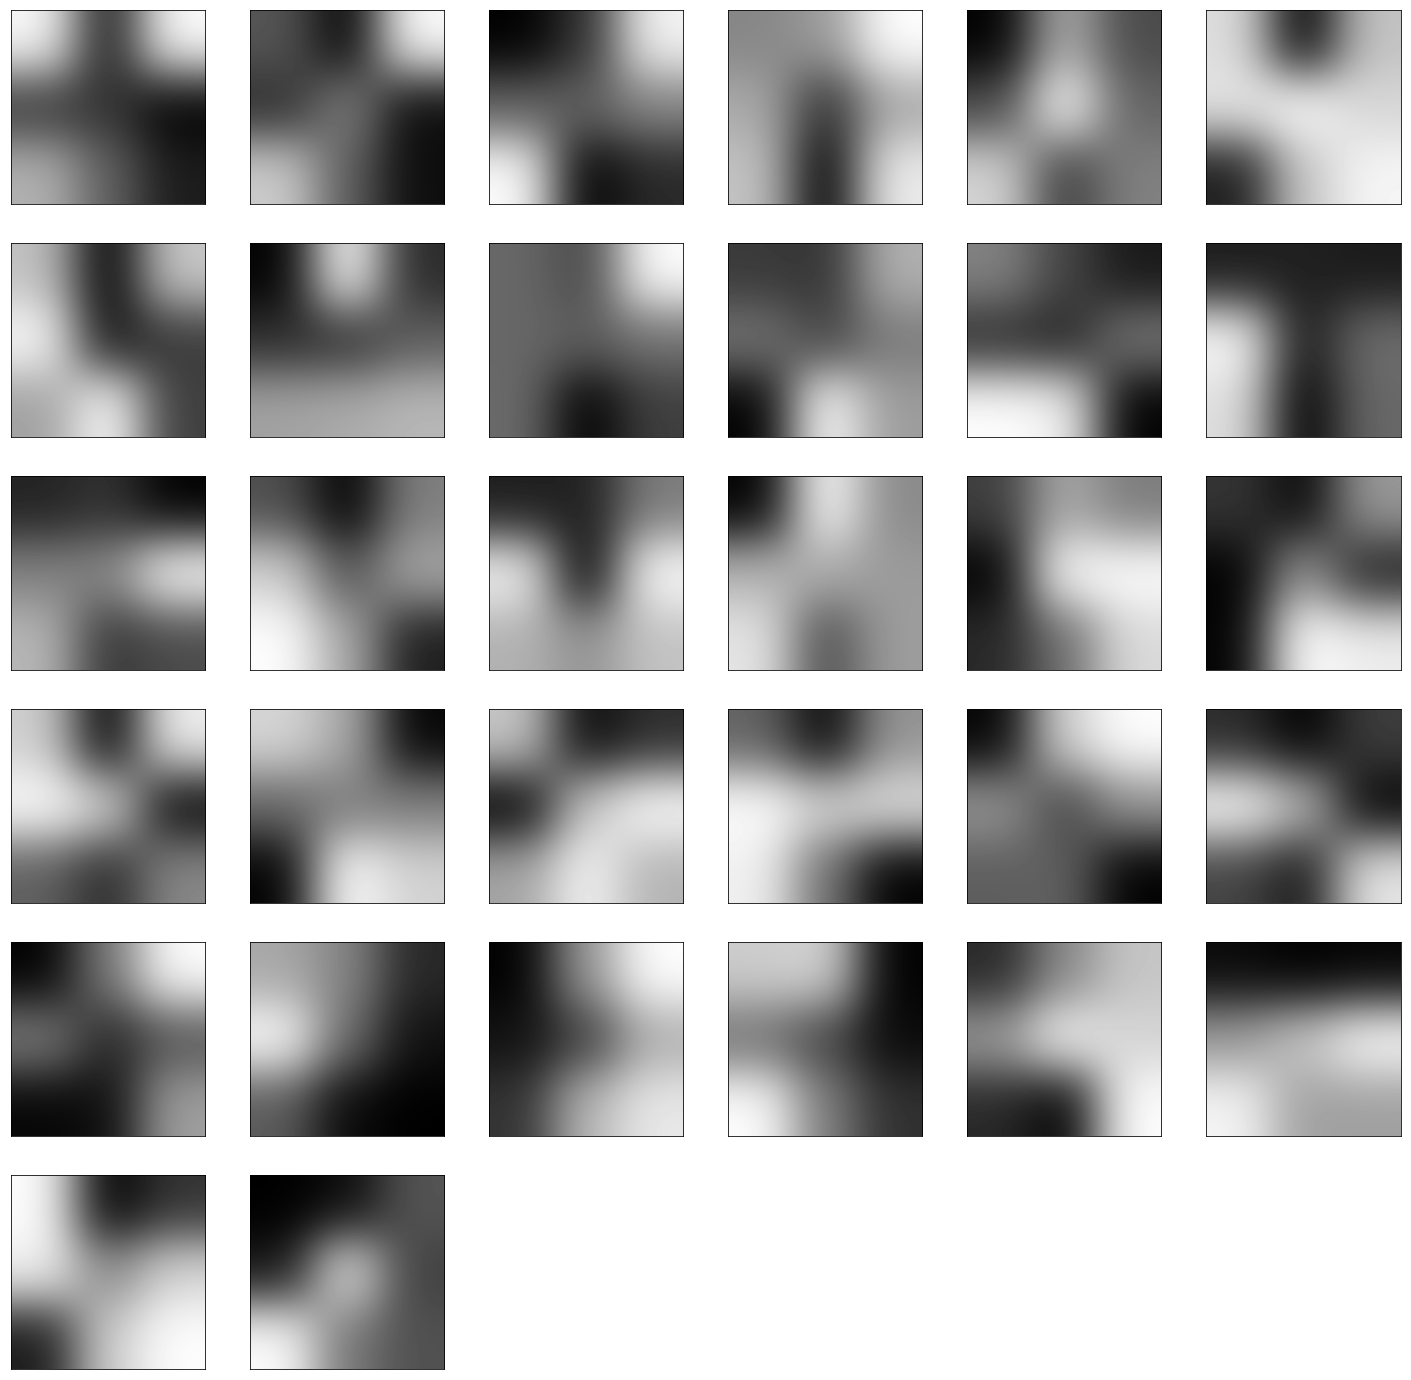

In [200]:
'''Acá se muestran los filtros "aprendidos" de la primera convolucion (32 filtros, como se puede ver en el detalle más arriba).
   Básicamente cargo los pesos de la respectiva capa para luego visualizarla.'''
weights, biases = model.layers[0].get_weights()
print(weights.shape)
W = np.array(weights[:,:,-1,3])
print(W.shape)
import matplotlib.pyplot as plt
canales = len(weights[-1,-1,-1,:])
IMG_SIZE2 = 25
fig=plt.figure(figsize=(IMG_SIZE2,IMG_SIZE2))
for i in range(canales):
    y = fig.add_subplot(6,6,i+1) #16*8=128, que es la cantidad de canales.
    W = np.array(weights[:,:,-1,i])
    y.imshow(W, cmap='gray', interpolation='gaussian')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()


In [41]:
import matplotlib.pyplot as plt

def ver_capa(model, sign): 
    '''Función que imprimie las distintas imagenes
       generadas por la capa X de la red neuronal
       convolucional.'''
    #sign_batch = np.expand_dims(sign,axis=0)
    sign_batch = sign.reshape(-1,ancho,alto,1)
    print(sign_batch.shape)
    conv_sign = model.predict(sign_batch)
    print(sign_batch.shape)
    #conv_sign = np.squeeze(conv_sign, axis=0)
    print(conv_sign.shape)
    #print(conv_sign[-1,:,:,0].shape)
    canales = int(len(conv_sign[-1,-1,-1,:]))
    IMG_SIZE2 = 32
    fig=plt.figure(figsize=(IMG_SIZE2,IMG_SIZE2))
    for i in range(canales):
        y = fig.add_subplot(8,16,i+1) #16*8=128, que es la cantidad de canales.
        y.imshow(conv_sign[-1,:,:,i], cmap='gray')
        y.axes.get_xaxis().set_visible(False)
        y.axes.get_yaxis().set_visible(False)
    plt.show()
    #plt.imshow(conv_sign[-1,:,:,1])
    
    

In [203]:
#imagen_prueba = cv2.imread("D:/kaggle/disco pare/test/20180810_135110.jpg", cv2.IMREAD_GRAYSCALE)
#imagen_prueba = cv2.resize(imagen_prueba, (ancho,alto))
#print(imagen_prueba.shape)
#ver_capa(model, imagen_prueba)


In [196]:
dir_test = "D:/kaggle/disco pare/test"
def crear_datos_test():
    testing_data = []
    for img in tqdm(os.listdir(dir_test)):
        ruta = os.path.join(dir_test,img)
        img_name = img.split('.')[1]
        img = cv2.imread(ruta,cv2.IMREAD_GRAYSCALE)
        img = cv2.equalizeHist(img)
        img = cv2.resize(img, (ancho,alto))
        testing_data.append([np.array(img), img_name])  
    random.shuffle(testing_data)
    #np.save('datos_prueba.npy', testing_data)
    return testing_data


 78%|███████████████████████████████████████████████████████████████▋                  | 73/94 [00:13<00:03,  5.38it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:17<00:00,  5.39it/s]


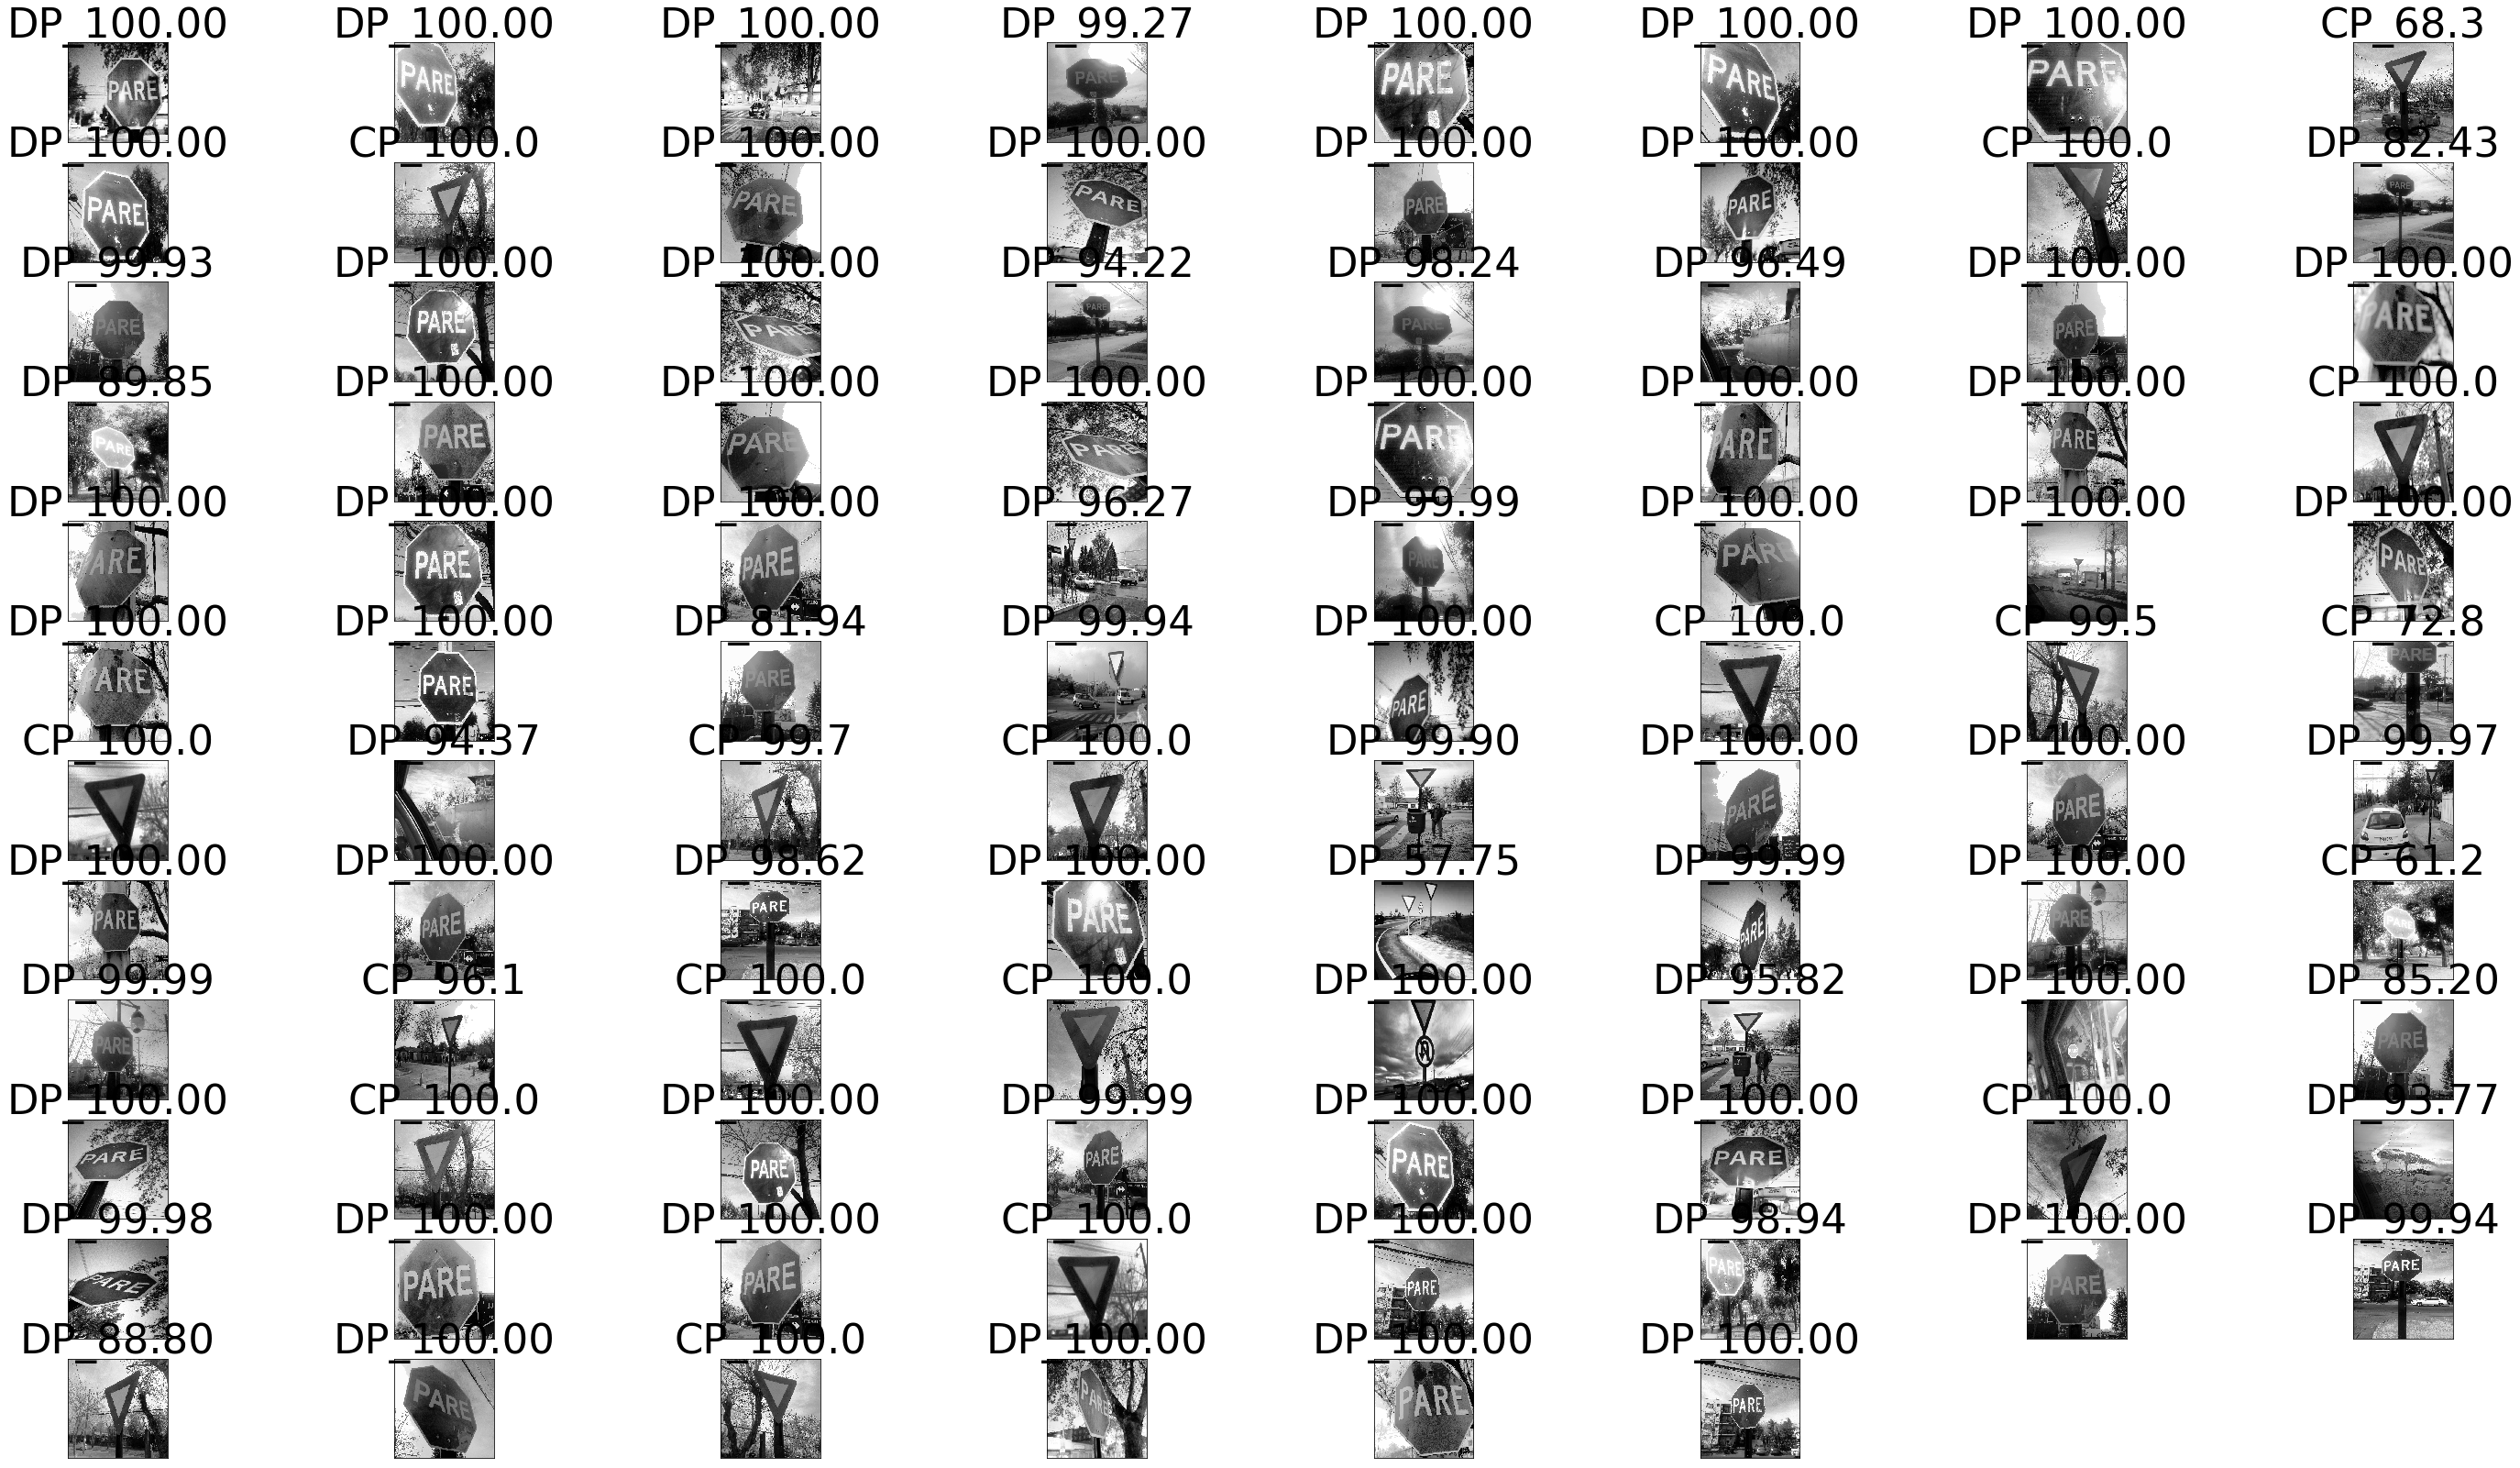

El porcentaje de precisión es de: 0.8404255319148937, con un total de 79/94 imagenes


In [197]:
import matplotlib.pyplot as plt

test_data = crear_datos_test()
#test_data = np.load('datos_de_entrenamiento.npy')

IMG_SIZE2 = 50
fig=plt.figure(figsize=(IMG_SIZE2,IMG_SIZE2))

datos = 0
for num,data in enumerate(test_data[:]):
    img_name = data[1]
    img_imagen = data[0]
    
    y = fig.add_subplot(21,8,num+1)
    orig = img_imagen
    data = img_imagen.reshape(-1,ancho,alto,1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_label='CP_{0:.1f}'.format(model_out[1]*100)
        if img_name == 'c': datos = datos + 1
    else: 
        str_label='DP_{0:.2f}'.format(model_out[0]*100)
        if img_name == 'd': datos = datos + 1
        
    y.imshow(img_imagen, cmap='gray')
    plt.title(str_label,fontsize=45)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()
print('El porcentaje de precisión es de: {}, con un total de {}/{} imagenes'.format(((datos)/len(test_data)),datos,len(test_data)))

In [178]:
imagen_prueba = cv2.imread("D:/kaggle/disco pare/test/20180810_131310.jpg", cv2.IMREAD_GRAYSCALE)
imagen_prueba = cv2.equalizeHist(imagen_prueba)
imagen_prueba = cv2.resize(imagen_prueba, (ancho,alto))
imagen_prueba = np.array(imagen_prueba)
print(imagen_prueba.shape)
imagen_prueba = imagen_prueba.reshape(-1,ancho,alto,1)
prediccion = model.predict(imagen_prueba)
print(prediccion[0]*100)
    
if np.argmax(prediccion) == 1: print('CP')
else: print('DP')

(400, 400)
[2.2636174e-05 9.9999977e+01]
CP


(200, 200)


c:\users\crist\appdata\local\programs\python\python35\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\crist\appdata\local\programs\python\python35\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


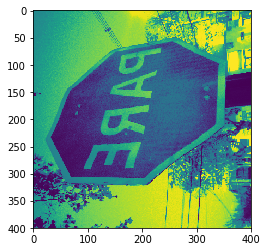

In [116]:
from skimage import io, color, exposure, transform
IMG_SIZE = 400

def preprocess_img(img):
    min_side = min(img.shape[:-1])
    centre = img.shape[0]//2, img.shape[1]//2
    print(centre)
    img = img[centre[0]-min_side//2:centre[0]+min_side//2,
              centre[1]-min_side//2:centre[1]+min_side//2]

    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    img = np.rollaxis(img,-1)

    return img

imagen_prueba = cv2.imread("D:/kaggle/disco pare/EntrenamientoS/1.DISCO_PARE.jpg", cv2.IMREAD_GRAYSCALE)
imagen_prueba = cv2.equalizeHist(imagen_prueba)
imagen_prueba = cv2.resize(imagen_prueba, (ancho,alto))
img = preprocess_img(imagen_prueba)
imgplot = plt.imshow(img)
plt.show()


In [161]:
'''Usando Keras, junto a su función ImageDataGenerator logro generar más de 3500 imagenes modificadas'''
img_principales = "D:\kaggle\disco pare\CEDA_EL_PASO"
  

datagen = ImageDataGenerator(
        rotation_range=50,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.15,
        horizontal_flip=True,
        fill_mode='nearest')


for img in os.listdir(img_principales):
    direc = "D:\kaggle\disco pare\CEDA_EL_PASO"
    ruta = os.path.join(direc,img)
    img = cv2.imread(ruta, cv2.IMREAD_GRAYSCALE)
    #img = cv2.equalizeHist(img)
    #img = cv2.resize(img, (ancho,alto))
    x = img_to_array(img)  # Arreglo Numpy de dimensiones (3, AnchoOriginal, AltoOriginal)
    x = x.reshape((1,) + x.shape)  # Arreglo numpy para ajustar las dimensiones(-1, canales, ancho, alto)

    # .flow() Comando para generar imágenes de forma aleatoria
    # Se guardan las imagenes en save_to_dir='dirección'
    i = 0
    for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='D:/kaggle/disco pare/Principales', save_prefix='CEDA-EL-PASO', save_format='jpg'):
        i += 1
        if i > 100:
            break 

In [162]:
'''Usando Keras, junto a su función ImageDataGenerator logro generar más de 3500 imagenes modificadas'''

img_principales = "D:\kaggle\disco pare\DISCO_PARE"
  

datagen = ImageDataGenerator(
        rotation_range=50,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.15,
        horizontal_flip=True,
        fill_mode='nearest')


for img in os.listdir(img_principales):
    direc = "D:\kaggle\disco pare\DISCO_PARE"
    ruta = os.path.join(direc,img)
    img = cv2.imread(ruta, cv2.IMREAD_GRAYSCALE)
    #img = cv2.equalizeHist(img)
    #img = cv2.resize(img, (ancho,alto))
    x = img_to_array(img)  # Arreglo Numpy de dimensiones (3, AnchoOriginal, AltoOriginal)
    x = x.reshape((1,) + x.shape)  # Arreglo numpy para ajustar las dimensiones(-1, canales, ancho, alto)

    # .flow() Comando para generar imágenes de forma aleatoria
    # Se guardan las imagenes en save_to_dir='dirección'
    i = 0
    for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='D:/kaggle/disco pare/Principales', save_prefix='DISCO-PARE', save_format='jpg'):
        i += 1
        if i > 100:
            break 